In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import sklearn.model_selection
import tensorflow_datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
# !ls gdrive/MyDrive

In [ ]:
# load raw training data
npzfile = np.load('/content/gdrive/MyDrive/X_and_y.npz')

In [ ]:
npzfile.files

['X', 'y']

In [ ]:
X = npzfile['X']
y = npzfile['y']

# split 
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, random_state=123)
# create a keras dataset object using the data
data_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(16)
data_val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(16)

In [ ]:
type(data_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
# remember we whould normalize the data before training the neural network
np.max(X)

255.0

In [ ]:
X.dtype

dtype('float32')

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# X contain microscopy images of cells
# X numpy array contains 2000 images, each with 128 rows and 128 columns
X.shape

(2000, 128, 128)

In [ ]:
type(y)

numpy.ndarray

In [ ]:
y.shape

(2000, 128, 128)

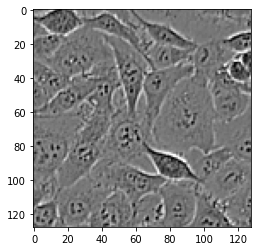

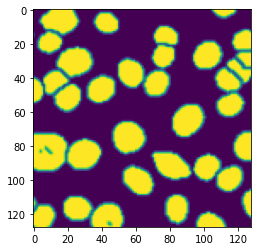

In [ ]:
idx = 7
plt.imshow(X[idx]/255, cmap = 'gray')
plt.figure()
plt.imshow(y[idx])

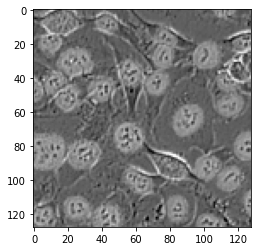

In [ ]:
idx = 7
# y is the ground truth labels
# code to superimpose the X images with the ground truth labels
plt.imshow(X[idx]/255 + .25*y[idx], cmap = 'gray')

In [ ]:
### setup U-Net model ###

# contracting path
# input layer: 1 because its a gray scale image
inputs = tf.keras.Input(shape=(128,128,1))

# 1st layer
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding ='same')(inputs)
# 2nd layer. half of these filters will be used for 4th upsampling 2d Conv layer
x_skip1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding ='same')(x)    

# 1st max pooling 2x2 layer
max1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_skip1)

# 3rd layer
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding ='same')(max1) 
# 4th layer. half of these filters will be used for 3rd upsampling 2d Conv layer
x_skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding ='same')(x)

# 2nd max pooling 2x2 layer
max2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_skip2)

# 5th layer 
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding ='same')(max2)
# 6th layer. half of these filters will be used for 2nd upsampling 2d Conv layer
x_skip3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding ='same')(x)

# 3rd max pooling 2x2 layer 
max3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_skip3)

# 7th layer
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding ='same')(max3)
# 8th layer. half of these filters will be used for 1st upsampling 2d Conv layer
x_skip4 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding ='same')(x)

# 4th max pooling 2x2 layer
max4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_skip4)

# 9th layer
x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding ='same')(max4)
# 10th layer
x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding ='same')(x)


# expansive path
# up-conv 2x2 layer
# Convolutional layer 2 step process 
# Step 1: 1st upsampling 2d
up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
# Step 2: 2d convolution layer. produce 512 filters, half of previous step.
up1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding ='same')(up1)

# concatonate up1 with 8th convolutional layer
x = tf.keras.layers.Concatenate(axis=-1)([up1, x_skip4])

# 11th layer
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding ='same')(x)
# 12th layer 
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding ='same')(x)

# up-conv 2x2 layer
# Convolutional layer 2 step process 
# Step 1: 1st upsampling 2d
up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
# Step 2: 2d convolution layer. produce 256 filters, half of previous step.
up2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding ='same')(up2)

# concatonate up2 with 6th convolutional layer
x = tf.keras.layers.Concatenate(axis=-1)([up2, x_skip3])

# 13th layer
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding ='same')(x)
# 14th layer 
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding ='same')(x)

# up-conv 2x2 layer
# Convolutional layer 2 step process 
# Step 1: 1st upsampling 2d
up3 = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
# Step 2: 2d convolution layer. produce 128 filters, half of previous step.
up3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding ='same')(up3)

# concatonate up3 with 4th convolutional layer
x = tf.keras.layers.Concatenate(axis=-1)([up3, x_skip2])

# 15th layer
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding ='same')(x)
# 16th layer 
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding ='same')(x)

# up-conv 2x2 layer
# Convolutional layer 2 step process 
# Step 1: 1st upsampling 2d
up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
# Step 2: 2d convolution layer. produce 64 filters, half of previous step.
up4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding ='same')(up4)

# concatonate up3 with 4th convolutional layer
x = tf.keras.layers.Concatenate(axis=-1)([up4, x_skip1])

# 17th layer
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding ='same')(x)
# 18th layer 
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding ='same')(x)

# apply dropout layers
x = tf.keras.layers.Dropout(0.5)(x)

# we want output of ur network to be one single image, so filter = 1
outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', padding='same')(x)    # output should also be an image, same as input

In [ ]:
outputs

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'conv2d_22')>

In [ ]:
# set up model
model = tf.keras.Model(inputs, outputs)

# set up learning rate
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

# compile model
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

# train model
# remember to change runtime type to 'GPU' to speed up the training process
history = model.fit(data_train, epochs=50, validation_data = data_val)

Epoch 1/50
94/94 [==============================] - 48s 328ms/step - loss: 0.5542 - accuracy: 0.6820 - val_loss: 0.3652 - val_accuracy: 0.7286
Epoch 2/50
94/94 [==============================] - 27s 283ms/step - loss: 0.3598 - accuracy: 0.7438 - val_loss: 0.2817 - val_accuracy: 0.7900
Epoch 3/50
94/94 [==============================] - 27s 289ms/step - loss: 0.2767 - accuracy: 0.7840 - val_loss: 0.4029 - val_accuracy: 0.7384
Epoch 4/50
94/94 [==============================] - 28s 295ms/step - loss: 0.2412 - accuracy: 0.7978 - val_loss: 0.2044 - val_accuracy: 0.8068
Epoch 5/50
94/94 [==============================] - 28s 296ms/step - loss: 0.2178 - accuracy: 0.8062 - val_loss: 0.1844 - val_accuracy: 0.8159
Epoch 6/50
94/94 [==============================] - 28s 295ms/step - loss: 0.2015 - accuracy: 0.8117 - val_loss: 0.1769 - val_accuracy: 0.8188
Epoch 7/50
94/94 [==============================] - 28s 296ms/step - loss: 0.1904 - accuracy: 0.8153 - val_loss: 0.1767 - val_accuracy: 0.8179

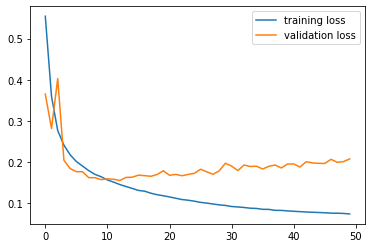

In [ ]:
# plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = 'validation loss')
plt.legend()

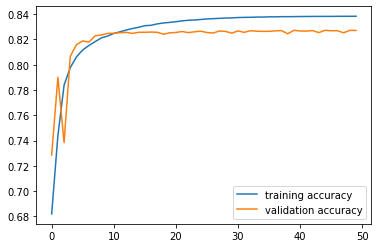

In [ ]:
# plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend()

In [ ]:
# make predictions with test images
# load test images
test_file = np.load('/content/gdrive/MyDrive/test_images.npz')

In [ ]:
test_file.files

['X']

In [ ]:
X_test = test_file["X"]

In [ ]:
# convert the array file into a tensor object and change the data type to a 32-bit float
X_test = tf.convert_to_tensor(X_test, np.float32)

In [ ]:
# make predictions
mask_test = model.predict(X_test)

In [ ]:
type(mask_test)

numpy.ndarray

In [ ]:
mask_test.shape

(2000, 128, 128, 1)

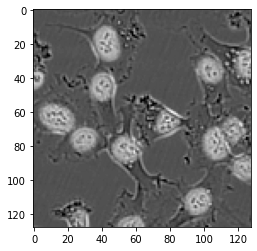

In [ ]:
# look at one of the predictive images
idx = 5
img = X_test[idx].numpy()
plt.imshow(img/255 + .5*mask_test[idx,:,:,0], cmap = 'gray')

In [ ]:
# import connected components library for counting cells
import cv2

i is:  1891
count is:  23


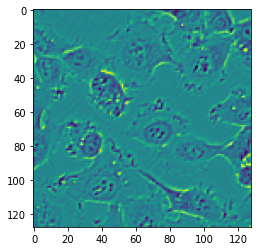

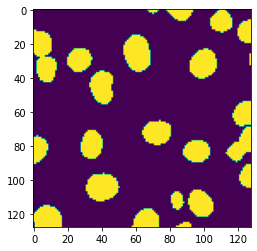

In [ ]:
# pull a random image from the test and round the target values to make hard labels
# then use cv2 command to count the number of cells

i = np.random.randint(2000)
print('i is: ', i)
img = X_test[i]
mask = mask_test[i,:,:,0]
plt.imshow(img)
plt.figure()
plt.imshow(np.round(mask))

count, _ = cv2.connectedComponents(np.uint8(np.round(mask)))
# Subtract 1. Don't include the background!
count = count - 1
print('count is: ', count)

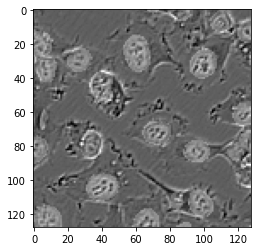

In [ ]:
# superimpose the above images
plt.imshow(img/255 + .25*np.round(mask), cmap = 'gray')

In [ ]:
# build database for prediction results
import pandas as pd

In [ ]:
# shape of test
mask_test.shape

(2000, 128, 128, 1)

In [ ]:
# length of array
len(mask_test)

2000

In [ ]:
# create two numpy arrays with zero values
indexes = np.zeros(2000)
counts = np.zeros(2000)

In [ ]:
# for loop that iterates through the prediction tests and counts the number of cells in each image
# then stored index number for image and count into numpy arrays

for i in range(len(mask_test)):
  mask = mask_test[i,:,:,0]
  count, _ = cv2.connectedComponents(np.uint8(np.round(mask)))
  # -1 to remove background from count
  count = count - 1

  # add index and count to arrays
  indexes[i] = i
  counts[i] = count

In [ ]:
# convert arrays to integer data types
indexes = indexes.astype(int)
counts = counts.astype(int)

In [ ]:
# create empty dataframe with column names 'index' and 'count'
results = pd.DataFrame(columns=["index","count"])

In [ ]:
# transfer array data to corresponding columns
results['index'] = indexes
results['count'] = counts

In [ ]:
results

,index,count
0,0,4
1,1,11
2,2,9
3,3,9
4,4,10
...,...,...
1995,1995,22
1996,1996,27
1997,1997,25
1998,1998,29


In [ ]:
# export dataframe to csv file
from google.colab import files
results.to_csv('ML U-Net Project Results.csv', encoding = 'utf-8-sig', index=False)
files.download('ML U-Net Project Results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>